In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
sns.set()

In [2]:
from nowcasting_functions import *

In [3]:
data = pd.read_csv('data/df_SIVEP_nowcast_allStates_08-02-2021.csv')
def get_state_data(df, state):
    df_state = df.copy()
    if state == 'Brazil':
        df_state.drop(columns=['State'], inplace=True)
        columns = list(df_state.columns)
        columns.remove('Deaths')
        df_state = df_state.groupby(columns, as_index=False)['Deaths'].sum()
        return df_state
    return df_state[df_state['State'] == state]

data = get_state_data(data, 'Brazil')
data_new = data.copy()

In [4]:
# Prepare the data for nowcast
data_new['Release_index'] = data_new.Release.astype('category').cat.codes
data_new = data_new[data_new['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
data_new = data_new[data_new['Release'] >= '2020-06-30'] # cut off early days as they are less relevant

In [5]:
data_new

,Date,Release,Date_index,Release_index,Deaths
5760,2020-06-30,2020-07-07,181,0,722
5761,2020-06-30,2020-07-14,181,1,933
5762,2020-06-30,2020-07-21,181,2,1025
5763,2020-06-30,2020-07-29,181,3,1091
5764,2020-06-30,2020-08-03,181,4,1116
...,...,...,...,...,...
9446,2021-02-03,2021-02-08,399,31,621
9447,2021-02-04,2021-02-08,400,31,486
9448,2021-02-05,2021-02-08,401,31,353
9449,2021-02-06,2021-02-08,402,31,225


In [6]:
def plot_results(df, result_nowcast, show_x=True, show_y=True, show_legend=True):
    date_nowcast = df['Date'].values[-1]
    reported, _ = nowcasting_prep(df, date_nowcast, maxD=10)
    nowcasted = result_nowcast
    
    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '_95% CrI', color = 'orange')
    label = 'GP model nowcast' # '50% CrI'
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = label, color = 'orange')

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color='blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

In [7]:
def plot_results_with_annotation(df, result_nowcast, show_x=True, show_y=True, show_legend=True):
    date_nowcast = df['Date'].values[-1]
    reported, _ = nowcasting_prep(df, date_nowcast, maxD=10)
    nowcasted = result_nowcast
    
    c1 = 'orange' # or 'tab:orange'
    c2 = 'blue' # or 'tab:blue'

    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '_95% CrI', color = c1)
    
    label = 'GP model nowcast' # '50% CrI'
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = label, color = c1)

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color=c2)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.text(max(x)-11, 8000, 'GP model\n nowcast', color = 'tab:orange', size=16)
    plt.text(max(x)-8, 4000, 'Reported', color = c2, size=16)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

### 2D GP model

In [8]:
model_2d = pystan.StanModel(file='stan_models/kron_multiply_lowerR.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32b4c9951dd36f95a9db2fa3b50ff581 NOW.


Model compiled


In [9]:
fit_2d, results_2d = fit_model(data_new, precompiled=False, modelname=model_2d, date_nowcast=None,
              maxD=12, iters=1200, warmup=600, chains=2, adapt_delta=0.90,
              max_treedepth=14, seed=667,
              pickle_run=False, save=False, savepath='')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


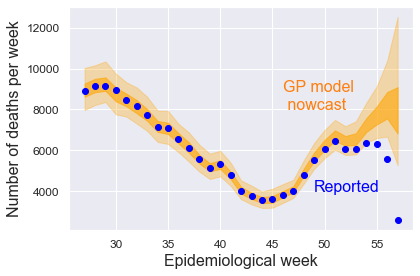

In [10]:
plot_results_with_annotation(data_new, results_2d, show_x=True, show_y=True, show_legend=False)

### 4xSE GP model

In [8]:
model_4compSE = pystan.StanModel(file='stan_models/4comp_longshort_SE.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fc993fd7bf0aedb8928d1ca1f5149e1 NOW.


Model compiled


In [9]:
fit_4compSE, results4compSE = fit_model(data_new, precompiled=False, modelname=model_4compSE, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


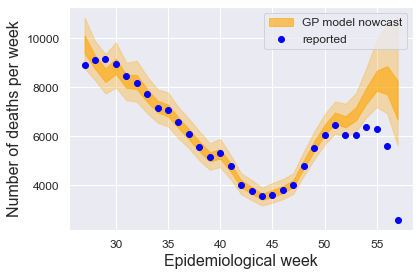

In [10]:
plot_results(data_new, results4compSE, show_x=True, show_y=True, show_legend=True)
plt.tight_layout()
plt.show()

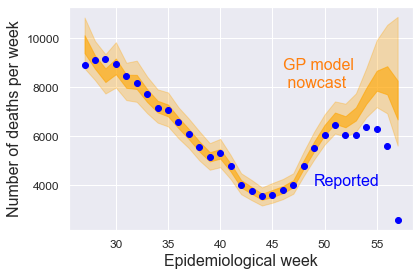

In [11]:
plot_results_with_annotation(data_new, results4compSE, show_x=True, show_y=True, show_legend=False)

### NobBS model

In [11]:
model_nobbs = pystan.StanModel(file='stan_models/nobbs.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50ab4c0f87d41cc6e3e4c401019d3bf2 NOW.


Model compiled


In [12]:
fit_nobbs, resultsnobbs = fit_model(data_new, precompiled=False, modelname=model_nobbs, date_nowcast=None,
              maxD=10, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=9876,
              pickle_run=False, save=False, savepath='')

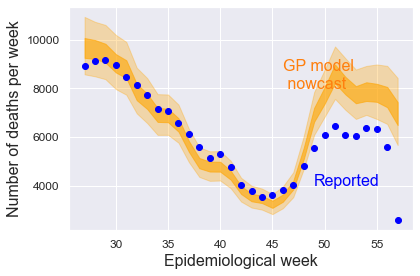

In [13]:
plot_results_with_annotation(data_new, resultsnobbs, show_x=True, show_y=True, show_legend=False)

# Plot delays

In [14]:
ground_truth, _   = nowcasting_prep(data_new, data_new.Date.values[-1], maxD=10)
ground_truth = ground_truth.iloc[:,:-1] # remove the all_deaths
ground_truth

,0,1,2,3,4,5,6,7,8,9,10
week,,,,,,,,,,,
0,3844,2179,810,520,142,268,154,178,132,82,597
1,3793,2457,922,281,329,224,214,153,85,68,598
2,4089,2363,536,581,329,234,212,107,62,80,567
3,4697,1412,918,481,333,234,144,97,55,86,491
4,2392,3250,1065,502,282,183,111,104,95,91,394
5,3326,2519,760,420,169,147,149,98,83,64,423
6,3002,2522,729,318,208,175,120,145,45,58,391
7,2959,2301,534,288,202,165,128,74,65,69,375
8,2913,2136,617,359,212,140,101,67,93,68,365


In [42]:
def plot_delays(ground_truth, fits, text, show_xlab=True, 
                show_ylab=True, show_legend=True,
               cri=50):
    
    fit_n_predict = fits.extract()['n_predict']
    n_predict = fit_n_predict.mean(axis = 0)
    n_predict_q025 = np.quantile(fit_n_predict,0.025,axis=0)
    n_predict_q975 = np.quantile(fit_n_predict,0.975,axis=0)
    n_predict_q25 = np.quantile(fit_n_predict,0.25,axis=0)
    n_predict_q75 = np.quantile(fit_n_predict,0.75,axis=0)
    
    if cri == 50:
        n_predict_low = n_predict_q25
        n_predict_high = n_predict_q75
    else:
        n_predict_low = n_predict_q025
        n_predict_high = n_predict_q975
    
    sns.set_palette(sns.color_palette("tab10"))
    x_true = ground_truth.index + 27
    x_nowcast =  np.array(range(n_predict_low.shape[0])) + 27

    plt.plot(x_true, ground_truth.iloc[:,0].values, ls = '-', alpha = 1,
             label = str(0))
    plt.fill_between(x_nowcast, n_predict_low[:,0],n_predict_high[:,0], alpha = 0.3)

    for c in range(1,6):
        plt.plot(x_true[0:-c], ground_truth.iloc[:,c].values[0:-c], ls = '-', label = str(c))
        plt.fill_between(x_nowcast, n_predict_low[:,c],n_predict_high[:,c], alpha = 0.3)

    if show_legend:
        plt.legend(ncol=3, loc='upper right',  title = 'Reporting delay (weeks)', 
                   title_fontsize=12, fontsize=12,)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.text(33, 3900, text, bbox=dict(alpha=0.1), fontsize=20)
    
    if show_xlab:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_ylab:
        plt.ylabel('Number of deaths per week', fontsize=16)
    
    if cri == 95:
        plt.ylim(0,5500)
    
    plt.tight_layout()

In [16]:
plot_delays(ground_truth, fit_4compSE, 'Additive GP model', show_legend=False)

NameError: name 'fit_4compSE' is not defined

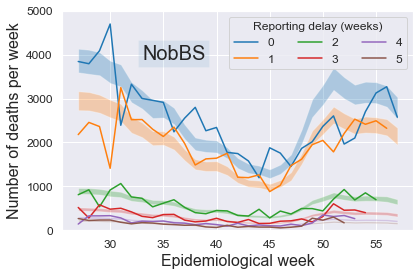

In [35]:
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_legend=True)

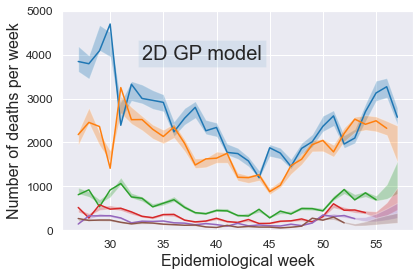

In [36]:
plot_delays(ground_truth, fit_2d, '2D GP model', show_legend=False)

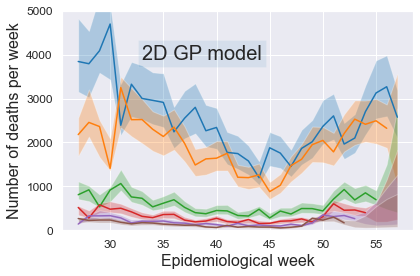

In [37]:
plot_delays(ground_truth, fit_2d, '2D GP model', show_legend=False, cri=95)

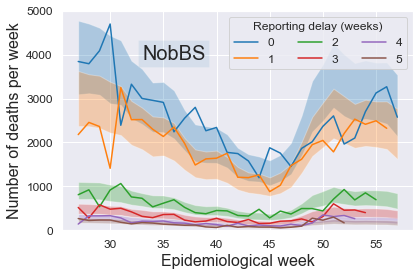

In [38]:
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_legend=True, cri=95)

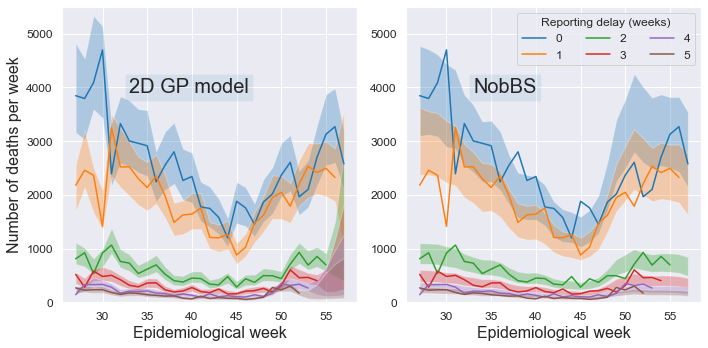

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_delays(ground_truth, fit_2d, '2D GP model', show_legend=False, cri=95)
plt.subplot(1,2,2)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_ylab=False, show_legend=True, cri=95)
plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/delays_combined_2d_nobbs_crI95.pdf', bbox_inches = 'tight')

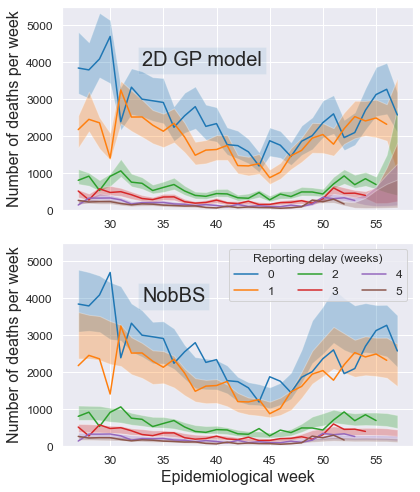

In [60]:
plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plot_delays(ground_truth, fit_2d, '2D GP model', show_xlab=False, show_legend=False, cri=95)
plt.subplot(2,1,2)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_legend=True, cri=95)
plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/delays_combined_2d_nobbs_crI95_vertical.pdf', bbox_inches = 'tight')